In [124]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.es.stop_words import STOP_WORDS
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import es_core_news_sm
import networkx as nx
import chart_studio.plotly as py
import spacy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['time', 'seed', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy



In [125]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@Noelia_Carrion9_tweets.csv')

In [126]:
tweets_user.head()

,id,created_at,text
0,1156508893893275648,2019-07-31 10:16:21,RT @voz_populi: Podemos e IU denuncian a ocho ...
1,1156508767934136321,2019-07-31 10:15:51,RT @MujeresRtve: Nuestro pesar por la muerte d...
2,1156508688506589184,2019-07-31 10:15:32,RT @elespanolcom: #Investigación | Científicos...
3,1156508626317656067,2019-07-31 10:15:18,RT @TheObjective_es: En la primera de las cuat...
4,1156508475406635008,2019-07-31 10:14:42,"RT @eldiarioes: ""Afilando los cuchillos"": iLe ..."


In [127]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [128]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [129]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [130]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [131]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [132]:
tweets_user['date'] = tweets_user['created_at']

In [133]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [134]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [135]:
nlp = es_core_news_sm.load(parser=True)

In [136]:
#nlp = spacy.load('es', parser=True)

In [137]:
nlp.Defaults.stop_words |= {"RT","próx", "xd", "rt", "htt", "parir", "sobrar"}

In [138]:
def spacy_tokenizer(sentence):
    sentence = re.sub(r'htt\S+', '', sentence)
    tokens = nlp(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}\w+', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [139]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [140]:
tweets_user['tokenized'][97]

['encantar',
 'gráfico',
 'manipular',
 'alterar',
 'percepción',
 'dato',
 'recopilar',
 'hilar']

In [72]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

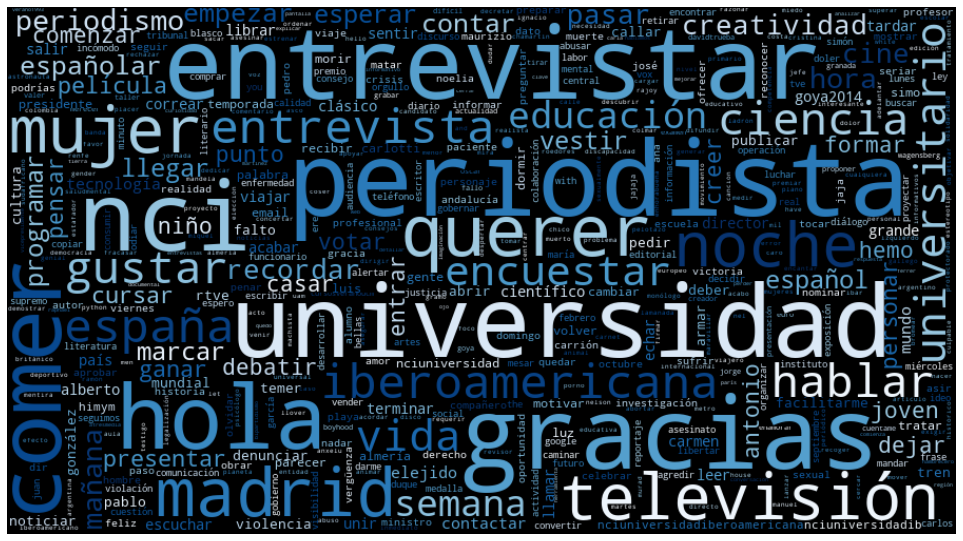

In [73]:
all_words = []
for line in tweets_user['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [141]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)

print(tfidf_matrix.shape)

CPU times: user 6.2 s, sys: 30.9 ms, total: 6.23 s
Wall time: 6.25 s
(641, 303)


In [142]:
terms = tfidf_vectorizer.get_feature_names()

In [143]:
array_matrix = tfidf_matrix.toarray()

In [144]:
first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
operación,0.603894
denunciar,0.563610
ministro,0.563610
abrir,0.000000
nciuniversidadiberoamericana,0.000000


In [145]:
vocab = tfidf_vectorizer.vocabulary_

In [146]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[-4.44089210e-16,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.22044605e-16,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])

In [147]:
umap = UMAP(n_components=2, n_neighbors=5)
embedding = umap.fit_transform(dist)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [148]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [149]:
umap_df.head()

,emb_1,emb_2
0,27.027782,-7.060453
1,29.791830,-11.936264
2,23.928488,-5.917158
3,29.930710,-10.301547
4,22.941481,-2.664488


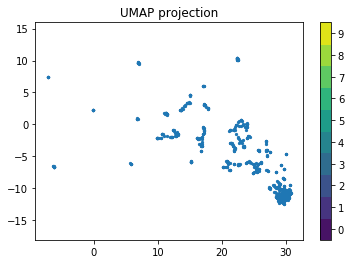

In [150]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

hdbscan = HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

hdbscan.labels_.max()

labels = hdbscan.labels_

fig = plt.figure(figsize=(15, 10))
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, hdbscan.fit_predict(embedding)))

In [151]:
num_clusters = 8

km = KMeans(n_clusters=num_clusters, init = 'k-means++',max_iter=300,n_init=10)

%time clustering = km.fit_predict(embedding)

clusters = km.labels_.tolist()
len(clusters)

CPU times: user 50.1 ms, sys: 2.04 ms, total: 52.2 ms
Wall time: 50.9 ms


641

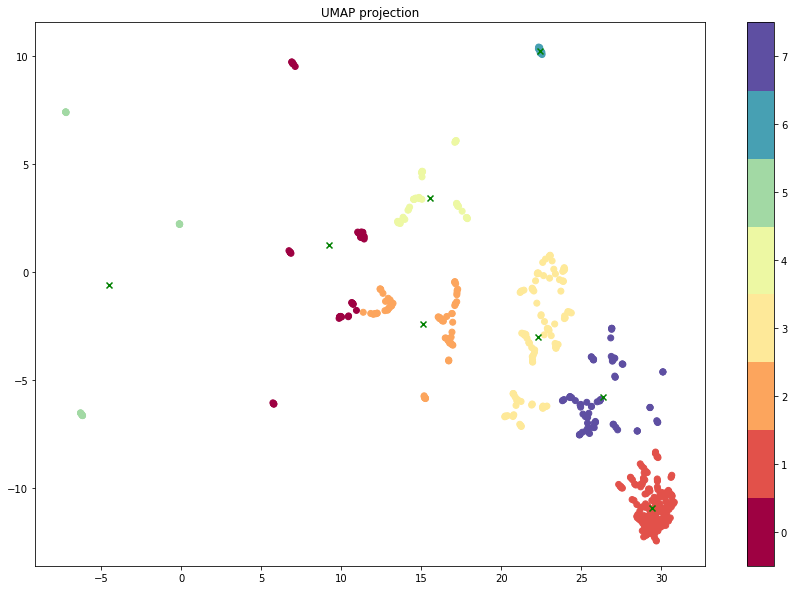

In [152]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
centers = np.array(km.cluster_centers_)

plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

In [153]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, km.predict(embedding)))

Silhouette Coefficient: 0.554


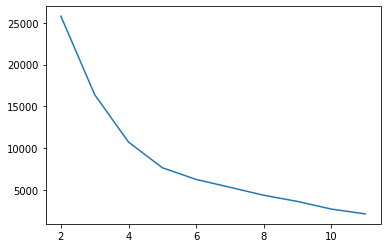

In [154]:
inertia = []

for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 12), inertia);

In [172]:
tweets = {'tweet': tweets_user['text'].values, "words": tweets_user['tokenized'].values, 'cluster': clusters, "mention": tweets_user['mention'].values, "RT": tweets_user['RT'].values, "date": tweets_user['date'].values}
cluster_user = pd.DataFrame(tweets, columns = ['tweet', 'words', "cluster", "mention", "RT", "date"])

In [173]:
cluster_user[cluster_user['cluster']==3].head()

,tweet,words,cluster,mention,RT,date
4,"RT @eldiarioes: ""Afilando los cuchillos"": iLe ...","[afilando, cuchillo, ile, calle, hablar, canci...",3,eldiarioes,1,2019-07-31
13,RT @javisalas: Tras minutos y más minutos escu...,"[minuto, minuto, escuchar, barbaridad, persona...",3,javisalas,1,2019-03-20
19,RT @el_pais: Ni todos los jóvenes tienen aspir...,"[joven, aspiración, académico, requerir, titul...",3,el_pais,1,2019-01-29
23,@palzaga Gracias por el aviso. He estado a pun...,"[gracias, avisar, punto, darle]",3,palzaga,0,2019-01-22
27,@Nosolopam Todos deberíamos ver #NoSoloDuelenL...,"[deber, nosoloduelenlosgolpes, monólogo, since...",3,Nosolopam,0,2019-01-21


In [176]:
cluster_user = cluster_user.reset_index(drop=True)

In [177]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,abrir,abusar,acabar,actividad,actualidad,agredir,alberto,almería,alumno,amor,...,viernes,violación,violencia,visibilidad,visitar,volver,votar,vox,wagensberg,you
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.409703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [179]:
top_words_cluster = get_df_from_cluster(5).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head(10)

leer                            5.591316
encuestar                       5.510590
universitario                   5.427241
hola                            5.083780
nciuniversidadiberoamericana    4.489609
gracia                          3.141227
editorial                       0.748496
marcar                          0.685244
programar                       0.680433
erar                            0.665881
dtype: float64

In [180]:
umap = UMAP(n_components=3, n_neighbors=5)
embedding = umap.fit_transform(dist)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [181]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(3)])

umap_df.head()

,emb_1,emb_2,emb_3
0,3.634485,8.910271,-20.543653
1,3.632035,12.059531,-18.812487
2,3.709842,7.385216,-20.235355
3,2.884903,11.414844,-20.033691
4,7.340675,7.013942,-18.832550


In [182]:
import plotly.express as px
#iris = px.data.iris()
fig = px.scatter_3d(umap_df, x='emb_1', y='emb_2', z='emb_3',
              color='emb_3', size_max=20,
            opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [183]:
tweets_user.mention.value_counts()

                                          200
el_pais                                    10
NCINoticias                                 9
elmundoes                                   9
CursosVeranoUCM                             7
                                         ... 
NCINoticias, gabrielawiener                 1
Culturizando                                1
bezdiario, ATEIberoamerica                  1
NCINoticias, noalestigma, consaludment      1
GlocalPressUrjc, ahorapodemos               1
Name: mention, Length: 330, dtype: int64

In [184]:
cluster_user = cluster_user[cluster_user['mention']!=""]

In [185]:
cluster_user['mention'].value_counts()

el_pais                                   10
NCINoticias                                9
elmundoes                                  9
CursosVeranoUCM                            7
ramonlobo                                  7
                                          ..
Culturizando                               1
bezdiario, ATEIberoamerica                 1
NCINoticias, noalestigma, consaludment     1
ibe_tv, luzsmellado, CursosVeranoUCM       1
NCIUniversidad, YouTube                    1
Name: mention, Length: 329, dtype: int64

In [186]:
cluster_user.head()

,tweet,words,cluster,mention,RT,date
0,RT @voz_populi: Podemos e IU denuncian a ocho ...,"[denunciar, ministro, delito, operación, chama...",7,voz_populi,1,2019-07-31
1,RT @MujeresRtve: Nuestro pesar por la muerte d...,"[muerte, mari, carmen, izquierdo, pionero, per...",1,MujeresRtve,1,2019-07-31
2,RT @elespanolcom: #Investigación | Científicos...,"[investigación, científicos, españolar, creer,...",7,elespanolcom,1,2019-07-31
3,RT @TheObjective_es: En la primera de las cuat...,"[jornada, holgar, convocar, renfe, cancelar, t...",1,TheObjective_es,1,2019-07-31
4,"RT @eldiarioes: ""Afilando los cuchillos"": iLe ...","[afilando, cuchillo, ile, calle, hablar, canci...",3,eldiarioes,1,2019-07-31


In [187]:
cluster_user['mention'].value_counts()

el_pais                                   10
NCINoticias                                9
elmundoes                                  9
CursosVeranoUCM                            7
ramonlobo                                  7
                                          ..
Culturizando                               1
bezdiario, ATEIberoamerica                 1
NCINoticias, noalestigma, consaludment     1
ibe_tv, luzsmellado, CursosVeranoUCM       1
NCIUniversidad, YouTube                    1
Name: mention, Length: 329, dtype: int64

In [189]:
cluster_user.to_csv("../output/cluster_user.csv")

In [49]:
df = pd.DataFrame({
    'user':['user1','user2','user2'],
    'mentioned_user':['jack,peter,anne','sophie','anne,user1']
})

In [50]:
df

,user,mentioned_user
0,user1,"jack,peter,anne"
1,user2,sophie
2,user2,"anne,user1"


/miniconda3/envs/py366/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/miniconda3/envs/py366/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



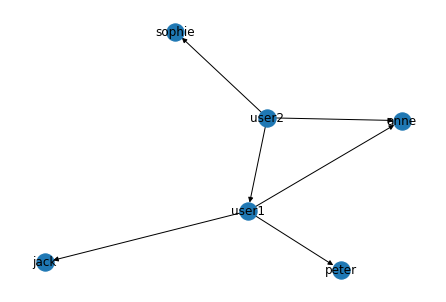

In [51]:
df['splitted_users'] = df['mentioned_user'].apply(lambda x: x.split(','))

G = nx.DiGraph()
for r in df.iterrows():
    for user in r[1]['splitted_users']:
        G.add_edge(r[1]['user'], user)
nx.draw(G, with_labels=True)

In [52]:
df['splitted_users'] 

0    [jack, peter, anne]
1               [sophie]
2          [anne, user1]
Name: splitted_users, dtype: object